# 1. Install Dependencies

In [1]:
!pip install tensorflow opencv-python-headless numpy matplotlib scikit-learn kagglehub


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install --upgrade pip


In [ ]:
!pip install kagglehub


In [2]:
pip install ipykernel


Note: you may need to restart the kernel to use updated packages.


# 2. Download Kaggle Dataset

In [1]:
import kagglehub
path = kagglehub.dataset_download("wobotintelligence/face-mask-detection-dataset")
print("Dataset downloaded to:", path)

import os
print(os.listdir(path))

100%|█████████████████████████████████████████████████████████████████████████████| 2.50G/2.50G [07:19<00:00, 6.10MB/s]

Extracting files...


Dataset downloaded to: C:\Users\Sam\.cache\kagglehub\datasets\wobotintelligence\face-mask-detection-dataset\versions\4
['Medical mask', 'submission.csv', 'train.csv']


# 4. Prepare Dataset Paths

In [2]:
base_path = os.path.join(path, "Medical mask/Medical mask/Medical Mask")
images_path = os.path.join(base_path, "images")
annotations_path = os.path.join(base_path, "annotations")

print("Images path:", images_path)
print("Annotations path:", annotations_path)

Images path: C:\Users\Sam\.cache\kagglehub\datasets\wobotintelligence\face-mask-detection-dataset\versions\4\Medical mask/Medical mask/Medical Mask\images
Annotations path: C:\Users\Sam\.cache\kagglehub\datasets\wobotintelligence\face-mask-detection-dataset\versions\4\Medical mask/Medical mask/Medical Mask\annotations


# 5️. Extract Faces

In [3]:
import os
import cv2
import json

output_base = "dataset"

# Create class folders
os.makedirs(os.path.join(output_base, "with_mask"), exist_ok=True)
os.makedirs(os.path.join(output_base, "without_mask"), exist_ok=True)
os.makedirs(os.path.join(output_base, "incorrect_mask"), exist_ok=True)

image_count = 0

for file in os.listdir(annotations_path):
    if file.endswith(".json"):

        with open(os.path.join(annotations_path, file)) as f:
            data = json.load(f)

        image_filename = data["FileName"]
        image_path = os.path.join(images_path, image_filename)

        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue

        # 🔥 Correct indentation starts here
        for obj in data["Annotations"]:

            label = obj.get("classname", "")

            if label == "face_with_mask":
                class_folder = "with_mask"

            elif label == "face_no_mask":
                class_folder = "without_mask"

            elif label == "face_with_mask_incorrect":
                class_folder = "incorrect_mask"

            else:
                continue  # Skip irrelevant labels like hat, glasses, etc.

            bbox = list(map(int, obj["BoundingBox"]))
            xmin, ymin, xmax, ymax = bbox

            # Ensure bounding box is valid
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(image.shape[1], xmax)
            ymax = min(image.shape[0], ymax)

            face = image[ymin:ymax, xmin:xmax]

            if face is None or face.size == 0:
                continue

            save_path = os.path.join(output_base, class_folder, f"{image_count}.jpg")
            cv2.imwrite(save_path, face)
            image_count += 1

print("✅ Dataset converted successfully!")
print("With mask:", len(os.listdir("dataset/with_mask")))
print("Without mask:", len(os.listdir("dataset/without_mask")))
print("Incorrect mask:", len(os.listdir("dataset/incorrect_mask")))


✅ Dataset converted successfully!
With mask: 4180
Without mask: 1569
Incorrect mask: 149


# 6️. Prepare Data Generators

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

IMG_SIZE = 224
BATCH_SIZE = 32
dataset_path = "dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# 🔥 CHANGE: class_mode='categorical'
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print("Class Indices:", train_generator.class_indices)

classes = train_generator.classes

# Compute balanced class weights (important because incorrect_mask is very small)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Found 4720 images belonging to 3 classes.
Found 1178 images belonging to 3 classes.
Class Indices: {'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2}
Class Weights: {0: np.float64(13.11111111111111), 1: np.float64(0.4704944178628389), 2: np.float64(1.2526539278131634)}


# 7️. Build & Train Model

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze base model

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# 🔥 CHANGE: 3 output neurons + softmax
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 🔥 CHANGE: categorical_crossentropy
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

model.save("mask_detector_3class.keras")


print("✅ Model training completed!")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.4250 - loss: 1.4374 - val_accuracy: 0.3659 - val_loss: 1.2112
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 145s 978ms/step - accuracy: 0.4727 - loss: 1.1727 - val_accuracy: 0.4397 - val_loss: 1.0727
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5112 - loss: 1.1010 - val_accuracy: 0.4610 - val_loss: 1.0133
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5233 - loss: 1.0533 - val_accuracy: 0.5017 - val_loss: 0.9567
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 147s 991ms/step - accuracy: 0.5561 - loss: 0.9764 - val_accuracy: 0.5560 - val_loss: 0.8942
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.5722 - loss: 0.9364 - val_accuracy: 0.6010 - val_loss: 0.8163
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.5909 - loss: 0.9027 - val_accuracy: 0.5806 - val_loss: 0.8229
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 14

# 8️. Fine-tune last layers

In [5]:
# Unfreeze last 30 layers
for layer in model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',   # 🔥 must be categorical
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights
)

model.save("mask_detector_finetuned_3class.keras")

print("✅ Fine-tuning completed!")


Epoch 1/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6398 - loss: 0.8807 - val_accuracy: 0.6783 - val_loss: 0.7012
Epoch 2/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 998ms/step - accuracy: 0.6542 - loss: 0.8048 - val_accuracy: 0.6740 - val_loss: 0.6943
Epoch 3/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 148s 1000ms/step - accuracy: 0.6835 - loss: 0.7017 - val_accuracy: 0.6842 - val_loss: 0.6643
Epoch 4/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6917 - loss: 0.6585 - val_accuracy: 0.7054 - val_loss: 0.6595
Epoch 5/5
148/148 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.7244 - loss: 0.5872 - val_accuracy: 0.6766 - val_loss: 0.6731
✅ Fine-tuning completed!


In [7]:
# saving the trained model
model.save("mask_detector_finetuned_3class.keras")


In [ ]:
from tensorflow.keras.models import load_model

# ✅ Load the previously trained and fine-tuned model from disk
# This allows you to use the model for predictions or evaluation
# without retraining after restarting your PC
model = load_model("mask_detector_finetuned_3class.keras")

# 9. TEST SET ACCURACY

In [8]:
test_loss, test_accuracy = model.evaluate(val_generator)

print("\n======================================")
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")
print("======================================")

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 576ms/step - accuracy: 0.6825 - loss: 0.6833

Test Set Accuracy: 68.25%


# 10. Evaluation

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Recreate validation generator WITHOUT shuffle
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # 🔥 must be categorical
    subset='validation',
    shuffle=False
)

# Predict probabilities
preds = model.predict(val_generator)

# Convert softmax probabilities to class index
predicted_classes = np.argmax(preds, axis=1)

# True labels
true_classes = val_generator.classes

# Get class labels
class_labels = list(val_generator.class_indices.keys())

print("Confusion Matrix:\n")
print(confusion_matrix(true_classes, predicted_classes))

print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 1178 images belonging to 3 classes.
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 846ms/step
Confusion Matrix:

[[ 16  11   2]
 [197 536 103]
 [ 31  28 254]]

Classification Report:

                precision    recall  f1-score   support

incorrect_mask       0.07      0.55      0.12        29
     with_mask       0.93      0.64      0.76       836
  without_mask       0.71      0.81      0.76       313

      accuracy                           0.68      1178
     macro avg       0.57      0.67      0.54      1178
  weighted avg       0.85      0.68      0.74      1178



# 11. ACCURACY CURVE FIGURE

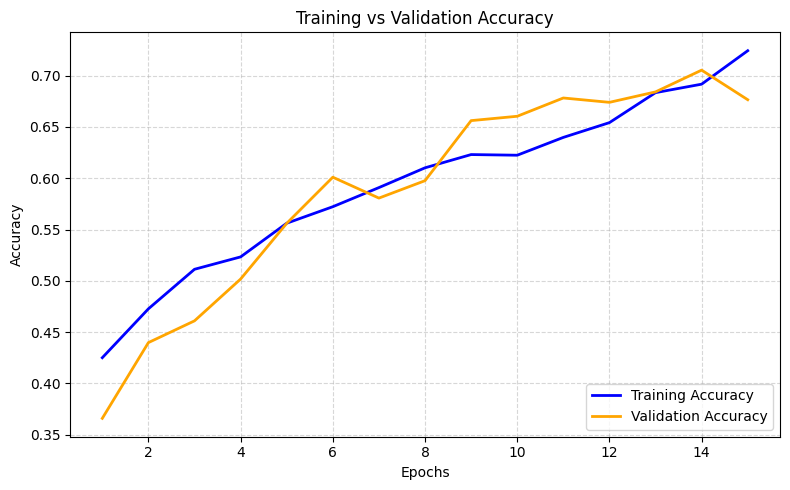

In [10]:
import matplotlib.pyplot as plt

# Combine initial training + fine-tuning
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))

plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc='lower right')   # <-- This explains blue & orange
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



# 11. Webcam Detection

In [14]:
import requests

# URLs for DNN face detector
prototxt_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
caffemodel_url = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

# Download deploy.prototxt
r = requests.get(prototxt_url)
with open("deploy.prototxt", "wb") as f:
    f.write(r.content)

# Download res10_300x300_ssd_iter_140000.caffemodel
r = requests.get(caffemodel_url)
with open("res10_300x300_ssd_iter_140000.caffemodel", "wb") as f:
    f.write(r.content)

print("✅ DNN face detector files downloaded!")


✅ DNN face detector files downloaded!


In [4]:
import cv2
from threading import Thread

class VideoStream:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src)
        self.ret, self.frame = self.cap.read()
        self.stopped = False

    def start(self):
        Thread(target=self.update, args=(), daemon=True).start()
        return self

    def update(self):
        while not self.stopped:
            self.ret, self.frame = self.cap.read()

    def read(self):
        return self.frame

    def stop(self):
        self.stopped = True
        self.cap.release()


In [2]:
!pip install tensorflow

In [ ]:
import cv2
import numpy as np
import time
from threading import Thread
from tensorflow.keras.models import load_model

# ==============================
# 1️⃣ Threaded Video Stream Class
# ==============================
class VideoStream:
    def __init__(self, src=0, width=640, height=480):
        self.cap = cv2.VideoCapture(src)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        self.ret, self.frame = self.cap.read()
        self.stopped = False

    def start(self):
        Thread(target=self.update, args=(), daemon=True).start()
        return self

    def update(self):
        while not self.stopped:
            self.ret, self.frame = self.cap.read()

    def read(self):
        return self.frame

    def stop(self):
        self.stopped = True
        self.cap.release()

# ==============================
# 2️⃣ Load Model & Face Detector
# ==============================
IMG_SIZE = 224
class_labels = ['incorrect_mask', 'with_mask', 'without_mask']

model = load_model("mask_detector_finetuned_3class.keras")

face_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

# ==============================
# 3️⃣ Start Threaded Webcam
# ==============================
vs = VideoStream(src=0, width=640, height=480).start()
prev_time = 0

# ==============================
# 4️⃣ Real-Time Detection Loop
# ==============================
while True:
    frame = vs.read()
    if frame is None:
        continue

    # Resize frame for faster face detection
    h, w = frame.shape[:2]
    scale_factor = 0.5  # adjust to trade-off speed vs accuracy
    small_frame = cv2.resize(frame, (int(w*scale_factor), int(h*scale_factor)))
    h_small, w_small = small_frame.shape[:2]

    # Detect faces
    blob = cv2.dnn.blobFromImage(small_frame, 1.0, (300, 300), (104, 117, 123))
    face_net.setInput(blob)
    detections = face_net.forward()

    faces = []
    boxes = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w_small, h_small, w_small, h_small])
            x1, y1, x2, y2 = box.astype("int")

            # Scale back to original frame size
            x1 = int(x1 / scale_factor)
            y1 = int(y1 / scale_factor)
            x2 = int(x2 / scale_factor)
            y2 = int(y2 / scale_factor)

            # Make sure box is valid
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w-1, x2), min(h-1, y2)

            face = frame[y1:y2, x1:x2]
            if face.size == 0:
                continue

            faces.append(face)
            boxes.append((x1, y1, x2, y2))

    # Predict masks for all faces at once
    if faces:
        face_batch = [cv2.resize(f, (IMG_SIZE, IMG_SIZE)) / 255.0 for f in faces]
        face_batch = np.array(face_batch)
        preds_batch = model.predict(face_batch, verbose=0)

        for (x1, y1, x2, y2), preds in zip(boxes, preds_batch):
            class_index = np.argmax(preds)
            confidence_score = preds[class_index]
            label = class_labels[class_index]

            if label == 'with_mask':
                color = (0, 255, 0)
            elif label == 'without_mask':
                color = (0, 0, 255)
            else:
                color = (0, 255, 255)

            text = f"{label} ({confidence_score*100:.1f}%)"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)


    cv2.imshow("Real-Time Mask Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ==============================
# 5️⃣ Cleanup
# ==============================
vs.stop()
cv2.destroyAllWindows()
